# Timeseries Forecasting on JENA Climate Dataset in R

In [ ]:
install.packages("keras3")

In [ ]:
library("keras3")

## Dataset Normalization, Splits

In [ ]:
df <- read.csv("jena_climate_2009_2016.csv", check.names = FALSE)
# Check the actual column names
colnames(df)
head(df)

[1] "Date Time"       "p (mbar)"        "T (degC)"        "Tpot (K)"       
 [5] "Tdew (degC)"     "rh (%)"          "VPmax (mbar)"    "VPact (mbar)"   
 [9] "VPdef (mbar)"    "sh (g/kg)"       "H2OC (mmol/mol)" "rho (g/m**3)"   
[13] "wv (m/s)"        "max. wv (m/s)"   "wd (deg)"

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
3,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
4,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
5,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
6,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7


In [ ]:
step <- 6
past <- 720
future <- 72
learning_rate <- 0.001
batch_size <- 256
epochs <- 20

In [ ]:
split_fraction <- 0.715
train_split <- floor(split_fraction * nrow(df))

In [ ]:
start <- past + future
end <- start + train_split

In [ ]:
train_data <- df[1:train_split-1, ]
val_data <- df[train_split:nrow(df), ]

In [ ]:
# Select numeric feature columns (skip column 1 which is Date Time)
# Use columns 2-8 (7 numeric feature columns)
# Convert to numeric matrix to ensure all values are numeric
x_train <- data.matrix(train_data[, 2:8])  # data.matrix converts to numeric matrix

# Select rows from start to end, and column 2 (index 1 in Python, but R is 1-indexed)
# Note: Python's iloc[start:end] is exclusive of end, so in R we use (start+1):end
y_train <- as.numeric(df[start:(end-1), 2])  # Ensure y_train is numeric

# Calculate sequence length
sequence_length <- as.integer(past / step)

In [ ]:
dataset_train = keras3::timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = step,
    batch_size = batch_size,
)

In [ ]:
# x_end should be number of rows, not columns
x_end <- nrow(val_data) - past - future
label_start <- train_split + past + future

In [ ]:
# Select rows 1 to x_end, and numeric feature columns (columns 2-8, skipping Date Time)
x_val <- data.matrix(val_data[1:x_end, 2:8])  # data.matrix converts to numeric matrix

# Select rows from label_start to end, and column 2 (index 1 in Python)
y_val <- as.numeric(df[label_start:nrow(df), 2])  # Ensure y_val is numeric

In [ ]:
dataset_val = keras3::timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = step,
    batch_size = batch_size,
)

In [ ]:
# Get the first batch from the dataset
# In R/keras3, we use as_iterator() and iter_next()
iter <- as_iterator(dataset_train)
batch <- iter_next(iter)
inputs <- batch[[1]]
targets <- batch[[2]]

# Print shapes (dimensions in R)
cat("Input shape:", paste(dim(inputs), collapse = " x "), "\n")
cat("Target shape:", paste(dim(targets), collapse = " x "), "\n")

Input shape: 256 x 120 x 7 
Target shape: 256 


## Creating the Model

In [ ]:
# Get input shape from the batch (excluding batch dimension)
# dim(inputs) is c(256, 120, 7) = (batch, sequence_length, features)
# For layer_input, we need c(sequence_length, features) = dim(inputs)[2:3]
input_shape <- dim(inputs)[2:3]  # c(120, 7)

# Create the model
inputs_layer <- keras3::layer_input(shape = input_shape)
lstm_out <- inputs_layer %>% keras3::layer_lstm(units = 32, return_sequences = FALSE)
outputs <- lstm_out %>% keras3::layer_dense(units = 1)

In [ ]:
model <- keras3::keras_model(inputs = inputs_layer, outputs = outputs)
model %>% keras3::compile(
    optimizer = keras3::optimizer_adam(learning_rate = learning_rate),
    loss = "mse"
)
# Use summary() directly (it's a generic function, not from keras3 namespace)
summary(model)

Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)          │ (None, 120, 7)           │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ lstm (LSTM)                       │ (None, 32)               │         5,120 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                     │ (None, 1)                │            33 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 5,153 (20.13 KB)
 Trainable params: 5,153 (20.13 KB)
 Non-trainable params: 0 (0.00 B)


In [ ]:
checkpoint_path <- "model.weights.h5"
early_stopping <- keras3::callback_early_stopping(
    monitor = "val_loss",
    patience = 10,
    min_delta = 0,
    restore_best_weights = TRUE
)

In [ ]:
model_cbk <- keras3::callback_model_checkpoint(
    filepath = checkpoint_path,
    monitor = "val_loss",
    verbose = 1,
    save_best_only = TRUE,
    save_weights_only = TRUE
)

In [ ]:
history <- model %>% keras3::fit(
    dataset_train,
    validation_data = dataset_val,
    epochs = epochs,
    callbacks = list(early_stopping, model_cbk)
)

In [ ]:
visualize_history = function(history, title) {
    loss <- history$metrics$loss
    val_loss <- history$metrics$val_loss
    epochs <- 1:length(loss)
    plot(epochs, loss, 'l', col = 'blue', lwd = 2,
         xlab = "Epochs", ylab = "Loss", main = title)
    lines(epochs, val_loss, col = 'red', lwd = 2)
    legend("topright", legend = c("Training", "Validation"),
           col = c("blue", "red"), lwd = 2)
}

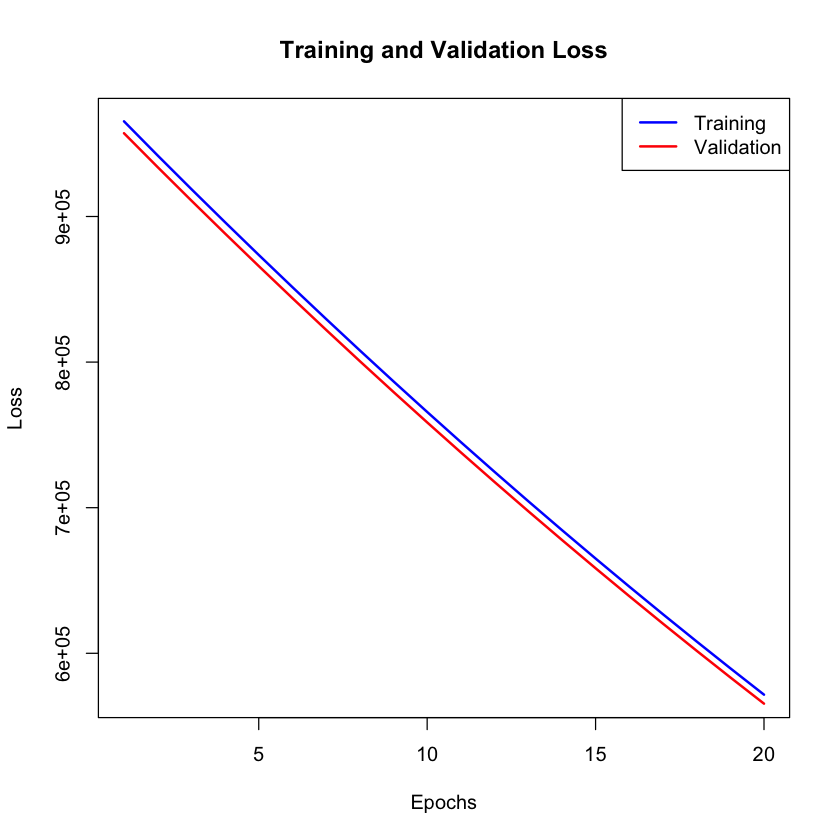

In [ ]:
visualize_history(history, "Training and Validation Loss")

## Inference/Prediction